In [35]:
import pandas as pd 
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
missing_value = train.isnull()
#print(missing_value)

missing_sum = train.isnull().sum()  #bu satırın sonucu bir seri 
#print(missing_sum)

missing_value = missing_sum[missing_sum > 0] # Sadece eksik değeri olan kolonlar
#Seriyi filtreler boolean yapmaz yani serinin filtrelenmiş halidir
missing_value = missing_value.sort_values(ascending=False) # Büyükten küçüğe sırala
#sort_value küçükten büyüğe sıralar. en çok eksik olan üste çıkması için ascending=False 
print(missing_value)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [37]:
#veri tipi object olan (kategorik/metinsel) kolonları none ile doldurdum
categorical_cols = train.select_dtypes(include='object').columns
train[categorical_cols] = train[categorical_cols].fillna("None")


In [38]:
numeric_cols = train.select_dtypes(include='number').columns
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())

In [39]:
train = pd.get_dummies(  #kategorik sütunları 0–1 sayısal sütunlara çevirir
    train, #Pandas fonksiyonları “havada” çalışmaz. Mutlaka bir DataFrame üzerinde çalışırlar.
    columns=categorical_cols, 
    drop_first=True)  #Dummy Variable Trap. Fazlalığı at
train.shape

(1460, 262)

In [40]:
#Target–Feature Ayrımı
y = train["SalePrice"] #tahmin etmek istediğim sütun burası. o yüzden bunu ayırdım
X = train.drop("SalePrice", axis=1) #trainden saleprice çıkardım. train değişmez ama çünkü X'e kopyaladım
#X	Modelin gördüğü girişler
#y	Modelin tahmin etmeye çalıştığı sonuç
print(X.shape)
print(y.shape)


(1460, 261)
(1460,)


In [41]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1168, 261)
(292, 261)
(1168,)
(292,)


In [42]:
#Model Training - Linear Regression Model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) #model X_traine bakar ve y_traini öğrenmeye çalışır

y_pred = lr_model.predict(X_test) #test verisiyle tahmin 

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression RMSE:", rmse_lr)

#RMSE -> Root Mean Squared Error
#tahminin gerçek fiyattan ortalama olarak ne kadar saptığını gösterir

Linear Regression RMSE: 82993.5131924286


In [43]:
#Ensemble Model Training - Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100, #100 karar ağacı
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE: ",rmse_rf)

Random Forest RMSE:  29275.221040147808


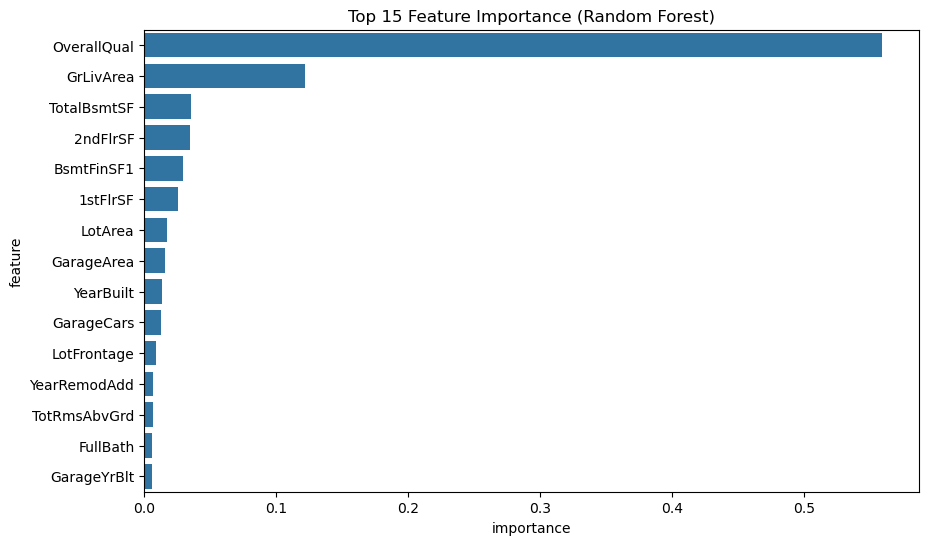

In [44]:
#Feature Importance Analizi
import pandas as pd
importances = rf_model.feature_importances_
#her feature ın modele katkı skoru -> toplamı 1 olmalı

feature_importance_df = pd.DataFrame({
    "feature":X.columns,
    "importance":importances
})
#feature isimleriyle birleştirme yapıldı

feature_importance_df = feature_importance_df.sort_values(
    by="importance",
    ascending=False
).head(15) #en önemli 15 özellik seçilir

#grafik çizme, fiyatı en çok etkileyen faktörleri gösterir
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance_df
)
plt.title("Top 15 Feature Importance (Random Forest)")
plt.show()  

In [45]:
#Model karşılaştırma tablosu
model_results = pd.DataFrame({
    "Model":["Linear Regeression", "Random Forest"],
    "RMSE":[rmse, rmse_rf]
})

model_results

,Model,RMSE
0,Linear Regeression,82993.513192
1,Random Forest,29275.221040


In [46]:
#Hyperparameter Tuning
#Modelin için en iyi ayarları otomatik olarak deneyip bulmaya çalışılır
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = { #denenecek ayarlar menüsü
    "n_estimators":[100,200], #kaç ağaç olsun
    "max_depth":[None, 10,20], #ağaçlar ne kadar derine inmeli
    "min_samples_split":[2,5], #bir dalın ikiye ayrılması için en az kaç veri lazım
    "min_samples_leaf": [1,2] # bir yaprakta en az kaç veri kalmalı
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf, # Hangi modeli eğiteyim? 
    param_grid, # Hangi ayarları deneyeyim? (Yukarıdaki menü)
    cv=5, #veriyi sadece bir kez "Train/Test" diye ayırmak bazen yanıltıcı olabilir. veriyi 5 eşit parçaya böler. 
    #Parça 1'i test, diğerlerini eğitim için kullanır -> Hatayı ölçer.
    #Parça 2'yi test, diğerlerini eğitim için kullanır -> Hatayı ölçer. ... bunu 5 kez yapar ve ortalamasını alır.
    scoring="neg_root_mean_squared_error", # Neye göre iyi/kötü diyeyim?
    n_jobs=-1 # Bilgisayarın tüm çekirdeklerini kullan (Hızlanmak için)
)

grid_search.fit(X_train, y_train)

#en iyi modeli bulma
best_rf = grid_search.best_estimator_
print("En iyi parametreler:", grid_search.best_estimator_)

#yeni rmse 
from sklearn.metrics import root_mean_squared_error
y_pred_best = best_rf.predict(X_test)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
print("Tuned Random Forest RMSE: ", rmse_best)

En iyi parametreler: RandomForestRegressor(min_samples_leaf=2, random_state=42)
Tuned Random Forest RMSE:  29129.287917263926


In [47]:
#XGBoost / Gradient Boosting Model
from sklearn.ensemble import GradientBoostingRegressor 
gbr = GradientBoostingRegressor(random_state=42) 
gbr.fit(X_train, y_train)
#bu modelde ağaçlar sırayla kurulur, hatalar düzeltilerek devam edilir

y_pred_gbr = gbr.predict(X_test)

rmse_gbr = root_mean_squared_error(y_test, y_pred_gbr)
print("Gradient Boosting RMSE:", rmse_gbr)

results = pd.DataFrame({
    "Model":["LinearRegression", "RandomForestRegressor", "Tuned Random Forest", "Gradient Boosting"],
    "RMSE":[rmse_lr, rmse_rf, rmse_best, rmse_gbr]
})
results

Gradient Boosting RMSE: 28598.809637750677


,Model,RMSE
0,LinearRegression,82993.513192
1,RandomForestRegressor,29275.221040
2,Tuned Random Forest,29129.287917
3,Gradient Boosting,28598.809638


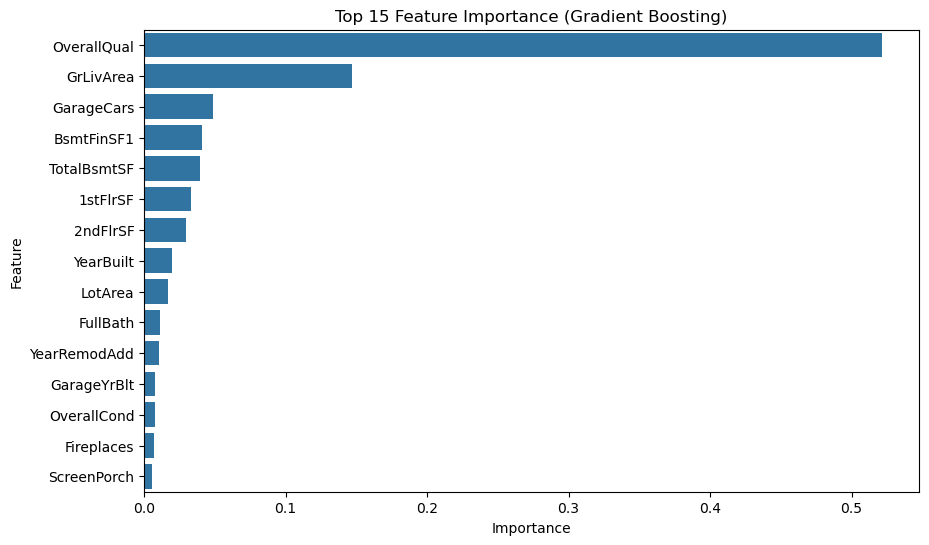

In [48]:
#Feature Importance Analysis
import pandas as pd
gb_importances = gbr.feature_importances_

feature_importance_gb = pd.DataFrame({
    "Feature":X.columns,
    "Importance":gb_importances
}).sort_values(by="Importance",ascending=False)

feature_importance_gb.head(15)

#grafikleştirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_gb.head(15)
)

plt.title("Top 15 Feature Importance (Gradient Boosting)")
plt.show()